<h2 style = 'color: orange'> EDA - Real Estate - Portugal: </h2>

The .csv files in this EDA were taken from Kaggle.com

In [311]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression

# Importando Libs de plots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import textwrap
sns.set_theme(style="whitegrid")

<h3 style = 'color: orange'> Reading files:</h3>

In [312]:
df = pd.read_csv('portugal_ads_proprieties.csv')
df

,Location,Rooms,Price,Area,Bathrooms,Condition,AdsType,ProprietyType
0,"Cortegaça, Ovar, Aveiro",4,2000.0,147.0,4.0,Used,Rent,House
1,"Mozelos, Santa Maria da Feira, Aveiro",2,5000.0,300.0,1.0,NaN,Rent,House
2,"Santa Maria da Feira, Travanca, Sanfins e Esp...",4,1200.0,134.0,2.0,Used,Rent,House
3,"Macinhata do Vouga, Águeda, Aveiro",4,2500.0,236.0,2.0,Renovated,Rent,House
4,"Oiã, Oliveira do Bairro, Aveiro",4,1200.0,240.0,NaN,NaN,Rent,House
...,...,...,...,...,...,...,...,...
62653,"Romarigães, Paredes de Coura, Viana do Castelo",1,500.0,100.0,1.0,New,Vacation,House
62654,"Cardielos e Serreleis, Viana do Castelo",3,850.0,120.0,1.0,Renovated,Vacation,House
62655,"Cardielos e Serreleis, Viana do Castelo",3,850.0,120.0,1.0,Renovated,Vacation,House
62656,"Chafé, Viana do Castelo",3,NaN,130.0,2.0,Used,Vacation,House


<h3 style = 'color: orange'> Data preprocessing:</h3>

In [313]:
# Columns' names: 

df.columns

Index(['Location', 'Rooms', 'Price', 'Area', 'Bathrooms', 'Condition',
       'AdsType', 'ProprietyType'],
      dtype='object')

In [314]:
new_columns_name = []

for old_names in df.columns:
    name_lowered = old_names.lower()
    new_columns_name.append(name_lowered)

df.columns = new_columns_name

In [315]:
new_columns_snake = {
    'adstype' : 'ads_type',
    'proprietytype' : 'propriety_type'    
}

df.rename(columns = new_columns_snake, inplace= True)

df.columns

Index(['location', 'rooms', 'price', 'area', 'bathrooms', 'condition',
       'ads_type', 'propriety_type'],
      dtype='object')

In [316]:
# Data info:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62658 entries, 0 to 62657
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        62658 non-null  object 
 1   rooms           62658 non-null  object 
 2   price           61488 non-null  float64
 3   area            62658 non-null  float64
 4   bathrooms       50146 non-null  float64
 5   condition       37533 non-null  object 
 6   ads_type        62658 non-null  object 
 7   propriety_type  62658 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.8+ MB


In [317]:
# Analysing 'rooms' dtype:

print(df['rooms'].unique())
df['rooms'].value_counts()

['4' '2' '3' '5' '0' '1' '6' '8' '7' '10 ou superior' '9']


rooms
3                 24343
4                 17025
2                  8427
5                  5510
6                  2211
1                  1780
0                  1327
7                   791
10 ou superior      544
8                   435
9                   265
Name: count, dtype: int64

In [318]:
# Adopting that 10 rooms information can be 10 or more rooms:

df['rooms'] = df['rooms'].map(lambda x: '10' if x == '10 ou superior' else x)
df['rooms'].value_counts()

rooms
3     24343
4     17025
2      8427
5      5510
6      2211
1      1780
0      1327
7       791
10      544
8       435
9       265
Name: count, dtype: int64

In [319]:
# Transforming the data in the 'rooms' column to INT:

df['rooms'] = df['rooms'].astype('int')
df['rooms'].dtypes

dtype('int32')

In [320]:
# Handling missing values:

df.isna().mean()

location          0.000000
rooms             0.000000
price             0.018673
area              0.000000
bathrooms         0.199687
condition         0.400986
ads_type          0.000000
propriety_type    0.000000
dtype: float64

In [321]:
# Excluding properties without price information:

df = df.dropna(subset=['price'])

In [322]:
# Filling in missing data from the 'condition' column:

columns_to_replace = ['condition']

for col in columns_to_replace:
    df[col].fillna('Unknown', inplace= True)

In [323]:
df.head()

,location,rooms,price,area,bathrooms,condition,ads_type,propriety_type
0,"Cortegaça, Ovar, Aveiro",4,2000.0,147.0,4.0,Used,Rent,House
1,"Mozelos, Santa Maria da Feira, Aveiro",2,5000.0,300.0,1.0,Unknown,Rent,House
2,"Santa Maria da Feira, Travanca, Sanfins e Esp...",4,1200.0,134.0,2.0,Used,Rent,House
3,"Macinhata do Vouga, Águeda, Aveiro",4,2500.0,236.0,2.0,Renovated,Rent,House
4,"Oiã, Oliveira do Bairro, Aveiro",4,1200.0,240.0,NaN,Unknown,Rent,House


In [324]:
# Filling in the missing values in the 'bathrooms' column with linear regression:

model = LinearRegression()

df_model = df.dropna(subset=['rooms', 'bathrooms', 'area'])

model.fit(df_model[['rooms', 'area']], df_model['bathrooms']) 

df['bathrooms'] = df.apply(lambda row: row['bathrooms'] if pd.notnull(row['bathrooms']) else model.predict([[row['rooms'], row['area']]])[0], axis=1)

In [325]:
# Transforming the data in the 'bathrooms' column to INT:

df['bathrooms'] = df['bathrooms'].round().astype('int')

In [326]:
df.isna().sum()

location          0
rooms             0
price             0
area              0
bathrooms         0
condition         0
ads_type          0
propriety_type    0
dtype: int64

In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61488 entries, 0 to 62655
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   location        61488 non-null  object 
 1   rooms           61488 non-null  int32  
 2   price           61488 non-null  float64
 3   area            61488 non-null  float64
 4   bathrooms       61488 non-null  int32  
 5   condition       61488 non-null  object 
 6   ads_type        61488 non-null  object 
 7   propriety_type  61488 non-null  object 
dtypes: float64(2), int32(2), object(4)
memory usage: 3.8+ MB


In [328]:
# Handling with duplicate data:

df.duplicated().sum()

5437

In [329]:
df.drop_duplicates()

,location,rooms,price,area,bathrooms,condition,ads_type,propriety_type
0,"Cortegaça, Ovar, Aveiro",4,2000.0,147.0,4,Used,Rent,House
1,"Mozelos, Santa Maria da Feira, Aveiro",2,5000.0,300.0,1,Unknown,Rent,House
2,"Santa Maria da Feira, Travanca, Sanfins e Esp...",4,1200.0,134.0,2,Used,Rent,House
3,"Macinhata do Vouga, Águeda, Aveiro",4,2500.0,236.0,2,Renovated,Rent,House
4,"Oiã, Oliveira do Bairro, Aveiro",4,1200.0,240.0,3,Unknown,Rent,House
...,...,...,...,...,...,...,...,...
62650,"Caminha (Matriz) e Vilarelho, Caminha, Viana ...",3,777.0,400.0,4,Unknown,Vacation,House
62651,"Caminha (Matriz) e Vilarelho, Caminha, Viana ...",6,1253.0,300.0,4,Unknown,Vacation,House
62652,"Arca e Ponte de Lima, Ponte de Lima, Viana do...",3,1400.0,162.0,2,Used,Vacation,House
62653,"Romarigães, Paredes de Coura, Viana do Castelo",1,500.0,100.0,1,New,Vacation,House


In [330]:
# Checking implicit duplicate data:

print(df['condition'].unique())
print(df['ads_type'].unique())
print(df['propriety_type'].unique())


['Used' 'Unknown' 'Renovated' 'New' 'Under construction' 'To recovery'
 'In ruin']
['Rent' 'Sell' 'Vacation']
['House']


In [331]:
# Handling with whitespace:

df['location'] = df['location'].str.strip()

In [332]:
# Creating the price per square meter column:

df['m2_price'] = df['price'] / df['area']
df = df.round(2)
df

,location,rooms,price,area,bathrooms,condition,ads_type,propriety_type,m2_price
0,"Cortegaça, Ovar, Aveiro",4,2000.0,147.0,4,Used,Rent,House,13.61
1,"Mozelos, Santa Maria da Feira, Aveiro",2,5000.0,300.0,1,Unknown,Rent,House,16.67
2,"Santa Maria da Feira, Travanca, Sanfins e Espa...",4,1200.0,134.0,2,Used,Rent,House,8.96
3,"Macinhata do Vouga, Águeda, Aveiro",4,2500.0,236.0,2,Renovated,Rent,House,10.59
4,"Oiã, Oliveira do Bairro, Aveiro",4,1200.0,240.0,3,Unknown,Rent,House,5.00
...,...,...,...,...,...,...,...,...,...
62651,"Caminha (Matriz) e Vilarelho, Caminha, Viana d...",6,1253.0,300.0,4,Unknown,Vacation,House,4.18
62652,"Arca e Ponte de Lima, Ponte de Lima, Viana do ...",3,1400.0,162.0,2,Used,Vacation,House,8.64
62653,"Romarigães, Paredes de Coura, Viana do Castelo",1,500.0,100.0,1,New,Vacation,House,5.00
62654,"Cardielos e Serreleis, Viana do Castelo",3,850.0,120.0,1,Renovated,Vacation,House,7.08


<h3 style = 'color: orange'> Data analyses:</h3>

The exploratory data analysis will focus on the Municipality of Porto (Sell).

It will be analyzed by Council/Parishes:

-   Properties' area (this order was changed after the observation that will be presented below);
-   The number of properties available; 
-   What property type (number of rooms) has the highest and lowest supply;
-   The average price by square meter;
-   Which three parishes have the highest average price;
-   Distribution of property prices (by square meter) in each parish according to the number of rooms;
-   Proportion of the average properties price according to the number of rooms.


In [333]:
# Porto's parishes:

porto_parishes = ['Aldoar, Foz do Douro e Nevogilde, Porto',
                  'Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, Porto',
                  'Lordelo do Ouro e Massarelos, Porto', 
                  ' Bonfim, Porto', 
                  'Campanhã, Porto', 
                  'Paranhos, Porto', 
                  'Ramalde, Porto'
                 ]

In [334]:
# Total properties for sale in Porto:

porto_df = df.query('location in @porto_parishes')
porto_sell_df = porto_df.query('ads_type == "Sell"')
porto_sell_df

,location,rooms,price,area,bathrooms,condition,ads_type,propriety_type,m2_price
37759,"Cedofeita, Santo Ildefonso, Sé, Miragaia, São ...",4,390030.0,171.00,3,Unknown,Sell,House,2280.88
37765,"Lordelo do Ouro e Massarelos, Porto",2,975000.0,160.40,2,Unknown,Sell,House,6078.55
37769,"Lordelo do Ouro e Massarelos, Porto",5,325000.0,180.00,3,Unknown,Sell,House,1805.56
37770,"Ramalde, Porto",4,1420000.0,271.00,3,Unknown,Sell,House,5239.85
37772,"Cedofeita, Santo Ildefonso, Sé, Miragaia, São ...",1,253450.0,62.00,2,Unknown,Sell,House,4087.90
...,...,...,...,...,...,...,...,...,...
47583,"Aldoar, Foz do Douro e Nevogilde, Porto",4,1750000.0,214.80,3,Unknown,Sell,House,8147.11
47584,"Aldoar, Foz do Douro e Nevogilde, Porto",3,3500000.0,273.70,2,Unknown,Sell,House,12787.72
47590,"Campanhã, Porto",1,159000.0,60.00,2,New,Sell,House,2650.00
47593,"Lordelo do Ouro e Massarelos, Porto",4,1350000.0,142.47,3,Unknown,Sell,House,9475.68


In [335]:
perishes_list = porto_sell_df['location'].unique().tolist()
perishes_list

['Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, Porto',
 'Lordelo do Ouro e Massarelos, Porto',
 'Ramalde, Porto',
 'Campanhã, Porto',
 'Aldoar, Foz do Douro e Nevogilde, Porto',
 'Paranhos, Porto']

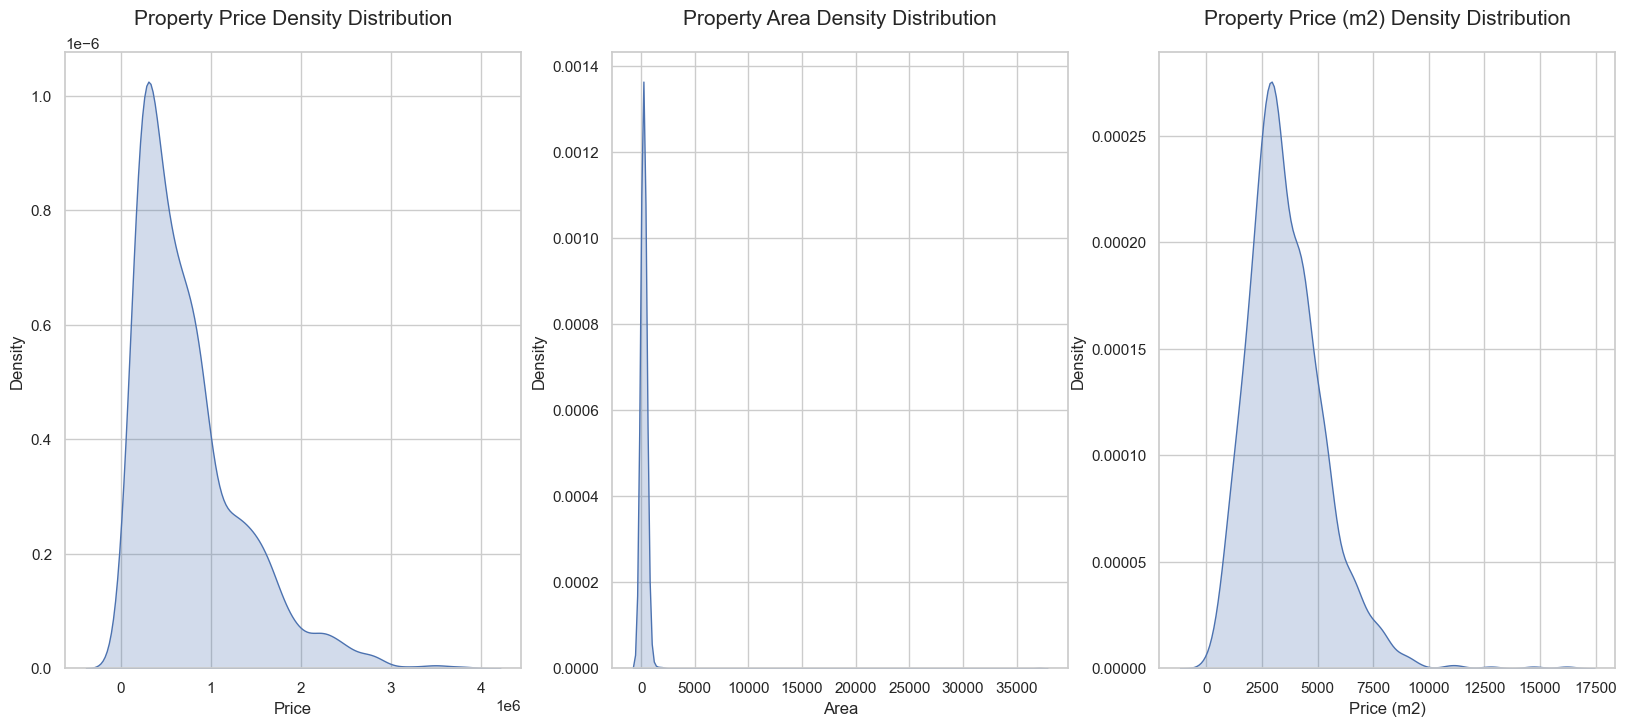

In [336]:
# Checking the distribution of data in the 'price', 'area' and 'm2_price' columns:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 8))

sns.kdeplot(data = porto_sell_df['price'],
            shade=True,
            ax = ax1);
ax1.set_title("Property Price Density Distribution", fontsize=15, pad=20);
ax1.set_xlabel("Price");
ax1.set_ylabel("Density");

sns.kdeplot(data = porto_sell_df['area'],
            shade=True,
            ax = ax2);
ax2.set_title("Property Area Density Distribution", fontsize=15, pad=20);
ax2.set_xlabel("Area");
ax2.set_ylabel("Density");

sns.kdeplot(data = porto_sell_df['m2_price'],
            shade=True,
            ax = ax3);
ax3.set_title("Property Price (m2) Density Distribution", fontsize=15, pad=20);
ax3.set_xlabel("Price (m2)");
ax3.set_ylabel("Density");

labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];


The graphs give me the following information:

-   The most common values in each distribution;
-   The first distribution presents positive asymmetry, suggesting a departure from a perfectly symmetric, or normal, distribution. However, the other two distributions, if we exclude outliers, appear to approximate a more symmetric shape, akin to a normal distribution. It is worth mentioning that the second distribution is very concentrated, so visualization can be misleading;
-   A considerable presence of outliers due to the concentration of data further to the left of the X axis;
-   The distributions apparently do not show great variability.


<h4 style = 'color: orange'> Properties' area (m2) by number of bedrooms:</h4>

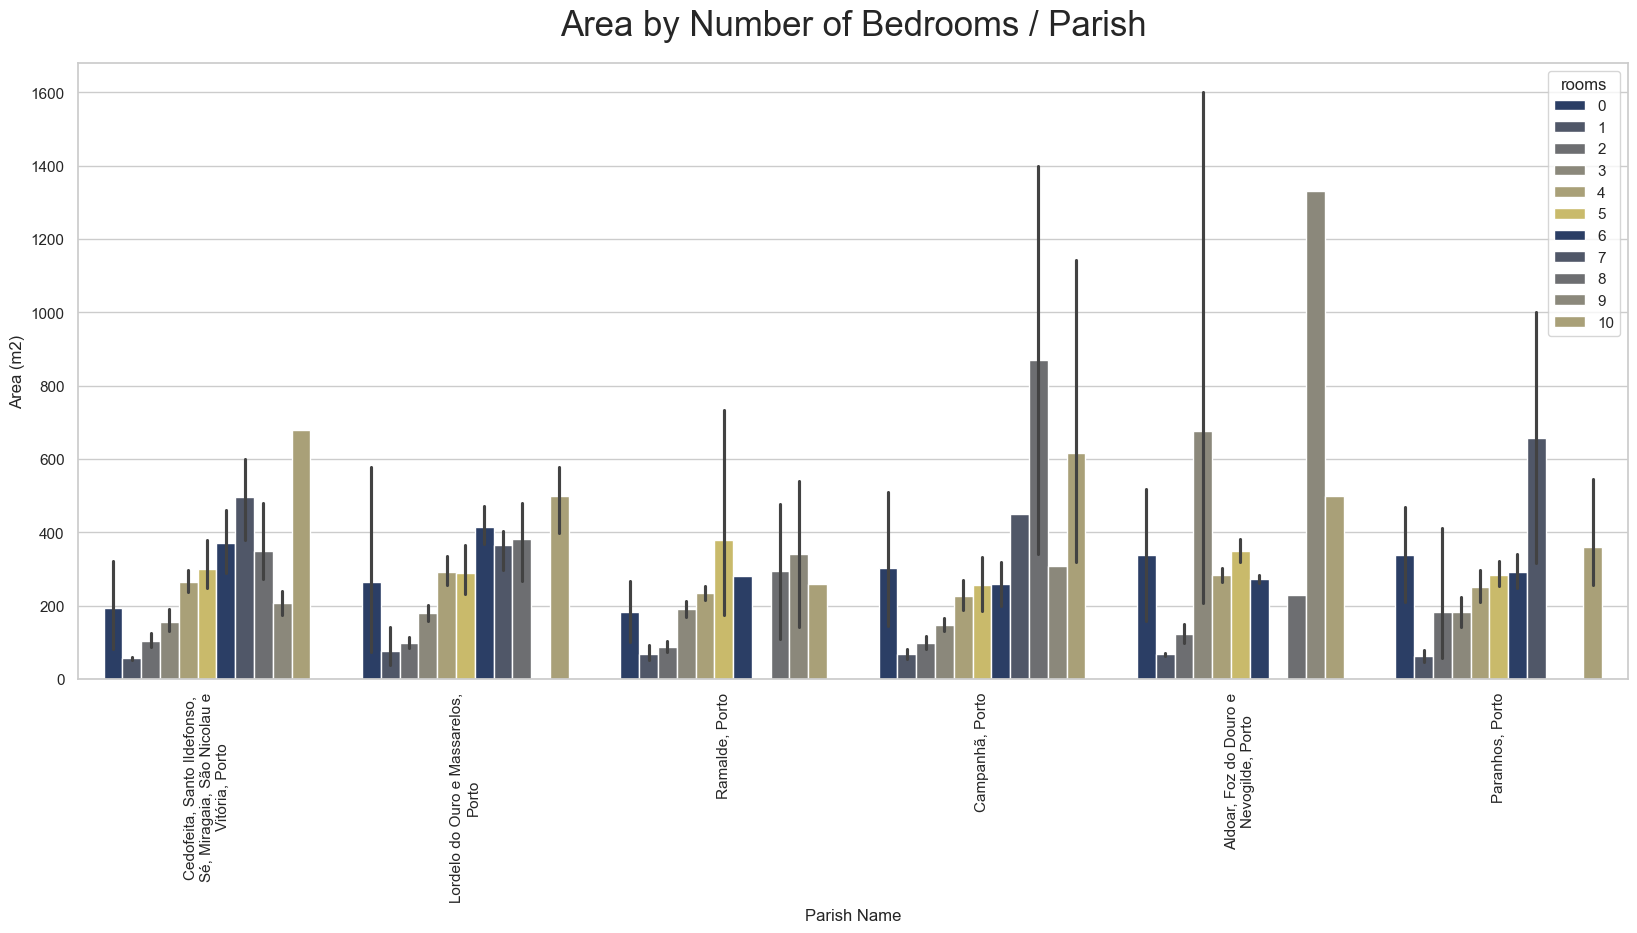

In [337]:
custom_palette = sns.color_palette("cividis", len(perishes_list))

fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.barplot(hue = 'rooms',
              x = 'location',
              y = 'area',
              palette=custom_palette,
              data = porto_sell_df, ax = ax1);

ax1.set_title("Area by Number of Bedrooms / Parish", fontsize=25, pad=20);
ax1.set_xlabel("Parish Name");
ax1.set_ylabel("Area (m2)");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);

In [338]:
# Number of properties by number of rooms:

porto_sell_df['rooms'].value_counts()

rooms
4     352
3     306
2     170
5     143
1      98
6      52
0      27
10     19
8      17
7      14
9       6
Name: count, dtype: int64

In [339]:
# Market share for 1-6 bedroom properties

porto_sell_df.query('rooms >= 1 and rooms <= 6').shape[0]/ porto_sell_df.shape[0]

0.9310631229235881

In [340]:
# Market share for 7-10 bedroom properties

porto_sell_df.query('rooms > 6').shape[0]/ porto_sell_df.shape[0]

0.046511627906976744

When analyzing the graph, it is clear that there is an error in the information regarding properties with 0 bedrooms (studios). The area does not match the type of property.

As this information may be compromising the analyses, I will continue this study with 1-6 bedroom apartments (93.10% of available properties).

I also chose to exclude properties with more than 6 bedrooms from the study because I consider that they are non-standard properties, also, there is a very low sample size. Their data could compromise the conclusion of the study. In addition to believing that the pricing of non-standard properties should not even be done using models.

When I look at the T3 apartments in Aldor, Foz do Douro and Nevogilde, I see that excluding outliers can be interesting for a solid analysis result.



In [341]:
# Working with 1 to 6 bedroom properties:

porto_sell_df = porto_sell_df.query('rooms >= 1 and rooms <= 6')
porto_sell_df['rooms'].describe()

count    1121.000000
mean        3.381802
std         1.264413
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: rooms, dtype: float64

In [342]:
# Excluding outliers:

# IQR 'price'
Q1_price = porto_sell_df['price'].quantile(0.25)
Q3_price = porto_sell_df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Outliers' limits 'price'
inferior_limit_price = Q1_price - 1.5 * IQR_price
superior_limit_price = Q3_price + 1.5 * IQR_price

# IQR 'area'
Q1_area = porto_sell_df['area'].quantile(0.25)
Q3_area = porto_sell_df['area'].quantile(0.75)
IQR_area = Q3_area - Q1_area

# Outliers' limits 'area'
inferior_limit_area = Q1_area - 1.5 * IQR_area
superior_limit_area = Q3_area + 1.5 * IQR_area

# Removing 'price' and 'area' outliers
porto_sell_df = porto_sell_df[(porto_sell_df['price'] >= inferior_limit_price) & (porto_sell_df['price'] <= superior_limit_price) &
                     (porto_sell_df['area'] >= inferior_limit_area) & (porto_sell_df['area'] <= superior_limit_area)]

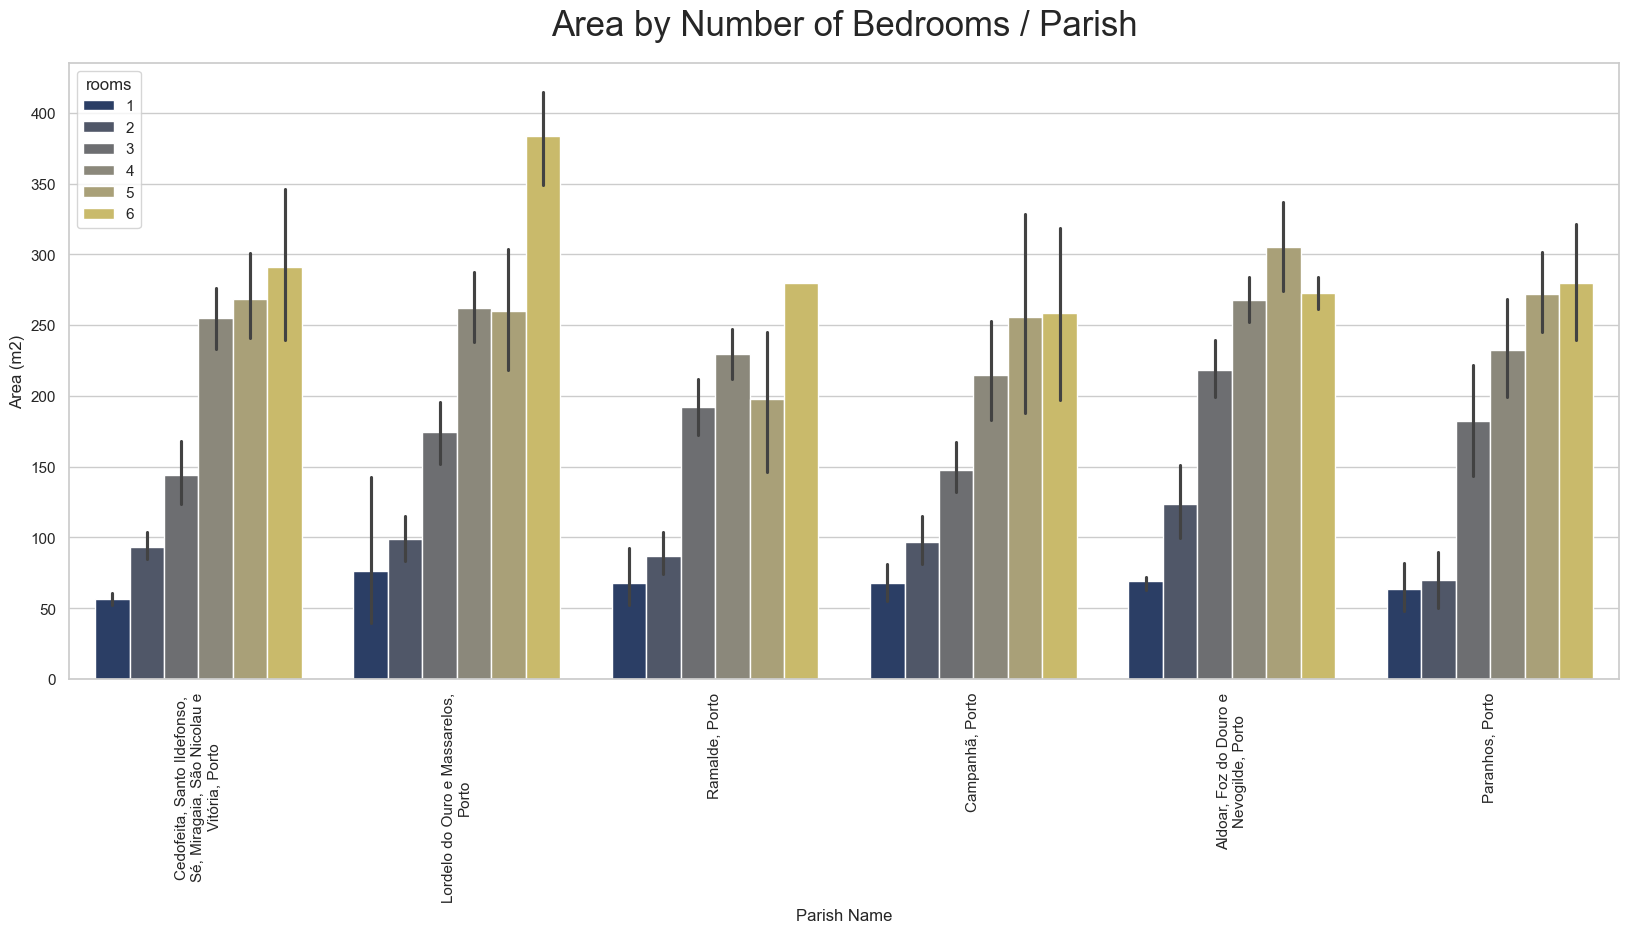

In [343]:
# Rechecking the chart

fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.barplot(hue = 'rooms',
              x = 'location',
              y = 'area',
              palette=custom_palette,
              data = porto_sell_df, ax = ax1);

ax1.set_title("Area by Number of Bedrooms / Parish", fontsize=25, pad=20);
ax1.set_xlabel("Parish Name");
ax1.set_ylabel("Area (m2)");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);

In [344]:
porto_sell_df.groupby('rooms')['area'].mean().round()

rooms
1     61.0
2     96.0
3    181.0
4    248.0
5    272.0
6    314.0
Name: area, dtype: float64

The average area of properties in Porto, according to the number of rooms, is:

-   1 bedrrom property:     61.0 m2;
-   2 bedrrom property:     96.0 m2;
-   3 bedrrom property:     181.0 m2;
-   4 bedrrom property:     248.0 m2;
-   5 bedrrom property:     272.0 m2;
-   6 bedrrom property:     314.0 m2.


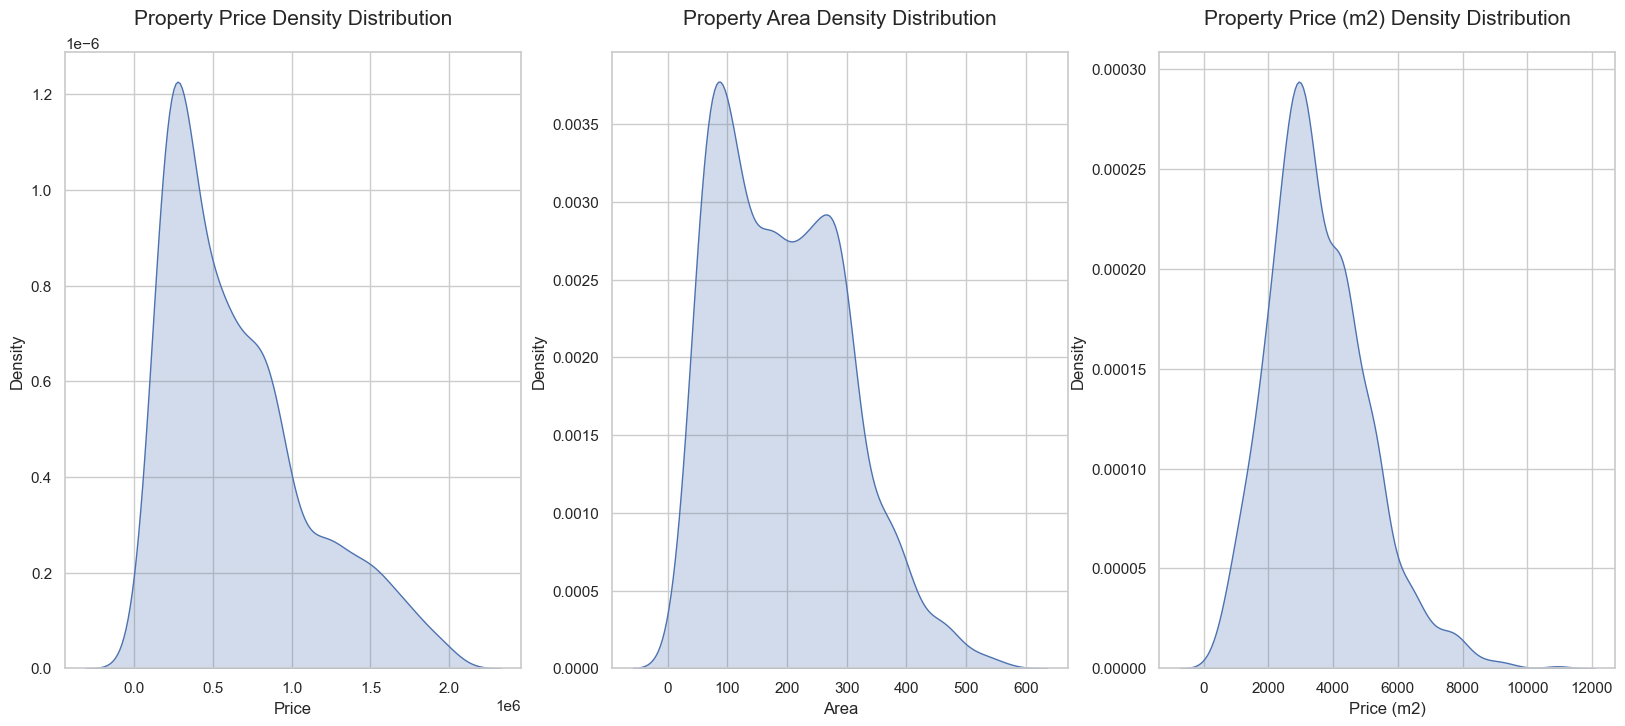

In [345]:
# Rechecking the distribution of data in the 'price', 'area' and 'm2_price' columns:

custom_palette = sns.color_palette("cividis", len(perishes_list))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 8))

sns.kdeplot(data = porto_sell_df['price'],
            shade=True,
            ax = ax1);
ax1.set_title("Property Price Density Distribution", fontsize=15, pad=20);
ax1.set_xlabel("Price");
ax1.set_ylabel("Density");

sns.kdeplot(data = porto_sell_df['area'],
            shade=True,
            ax = ax2);
ax2.set_title("Property Area Density Distribution", fontsize=15, pad=20);
ax2.set_xlabel("Area");
ax2.set_ylabel("Density");

sns.kdeplot(data = porto_sell_df['m2_price'],
            shade=True,
            ax = ax3);
ax3.set_title("Property Price (m2) Density Distribution", fontsize=15, pad=20);
ax3.set_xlabel("Price (m2)");
ax3.set_ylabel("Density");

labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];

After removing the outliers, the graphs now have a better view and I highlight the following observation:

-   The second distribution presents a second peak, which indicates more than one concentration of property size (m2).

<h4 style = 'color: orange'> The number of properties available:</h4>

In [346]:
porto_sell_df.shape[0]

1058

There are 1058 1-6 bedroom properties for sale in Porto, on selected data.

In [347]:
# Properties for sale per parishes:

porto_sell_df.groupby('location')['ads_type'].count().sort_values(ascending= False)

location
Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, Porto    243
Aldoar, Foz do Douro e Nevogilde, Porto                                   240
Campanhã, Porto                                                           191
Ramalde, Porto                                                            162
Lordelo do Ouro e Massarelos, Porto                                       117
Paranhos, Porto                                                           105
Name: ads_type, dtype: int64

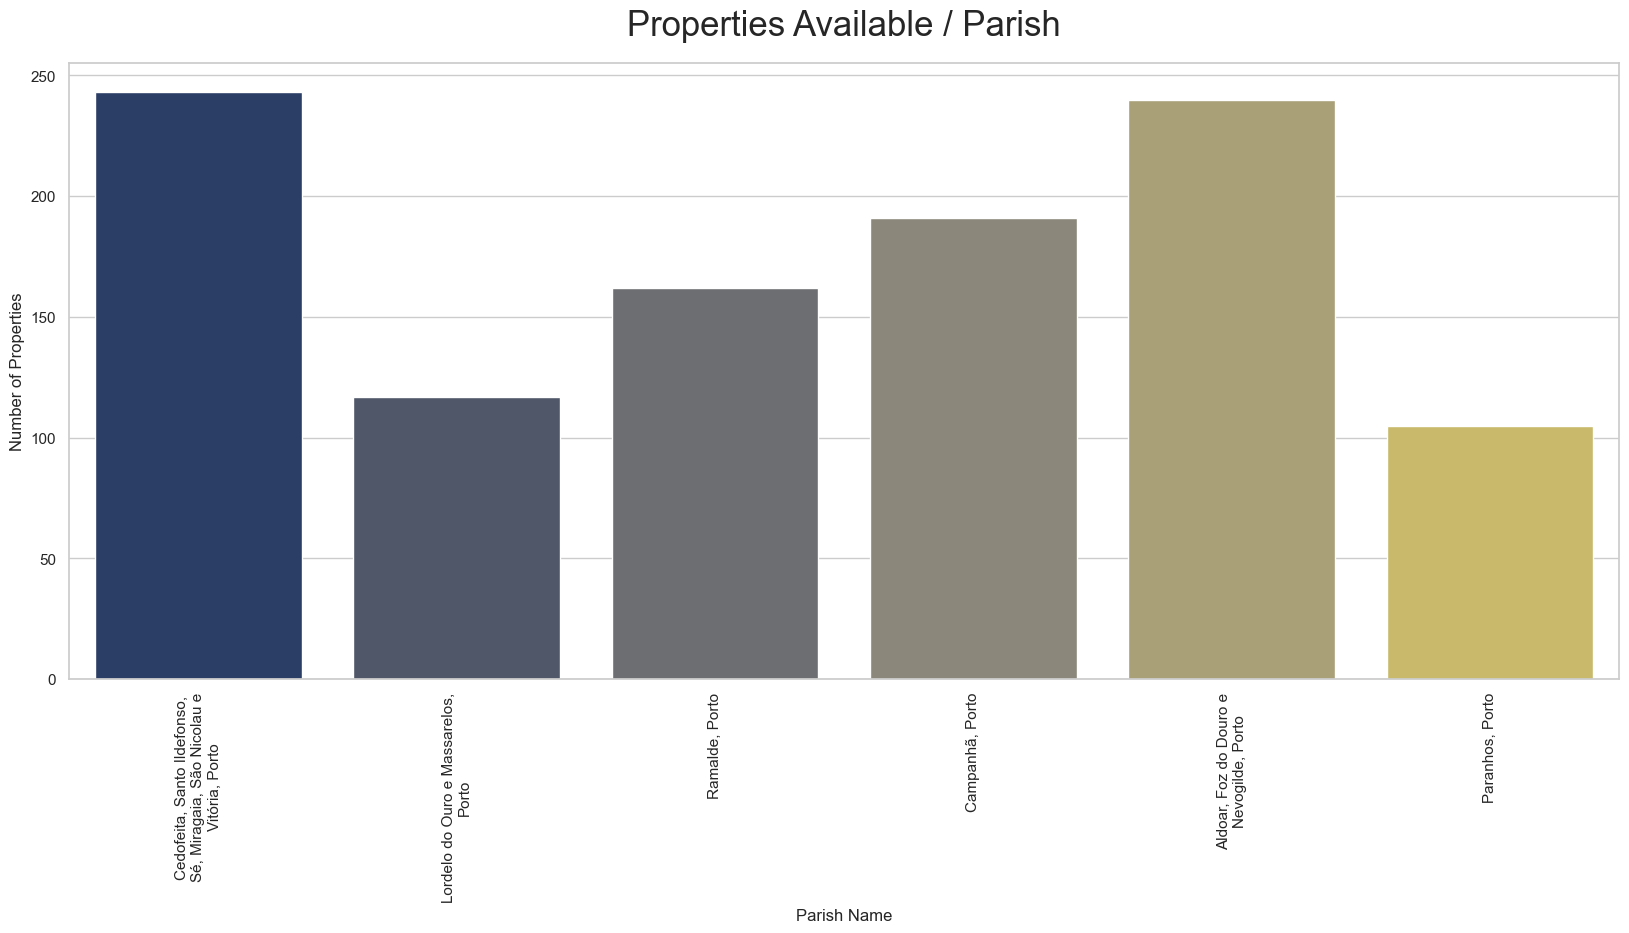

In [348]:
fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.countplot(hue = 'location',
             x = 'location',
             palette=custom_palette,
             data = porto_sell_df, ax = ax1);

ax1.set_title("Properties Available / Parish", fontsize=25, pad=20);
ax1.set_xlabel("Parish Name");
ax1.set_ylabel("Number of Properties");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);

The parishes with more 1-6 bedroom properties available are:

-   Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, Porto =     243
-   Aldoar, Foz do Douro e Nevogilde, Porto =                                   240
-   Campanhã, Porto =                                                            191

<h4 style = 'color: orange'> Properties available by number of bedrooms:</h4>

In [349]:
porto_sell_df_bedrooms = porto_sell_df.groupby('rooms')['location'].count().sort_values(ascending=False)
porto_sell_df_bedrooms

rooms
4    331
3    301
2    168
5    115
1     98
6     45
Name: location, dtype: int64

There is more availability of 4, 3 and 2 bedroom properties for sale.

In [350]:
# Market share for 4, 3 and 2 bedroom properties

porto_sell_df.query('rooms >= 2 and rooms <= 4').shape[0]/ porto_sell_df.shape[0]

0.7561436672967864

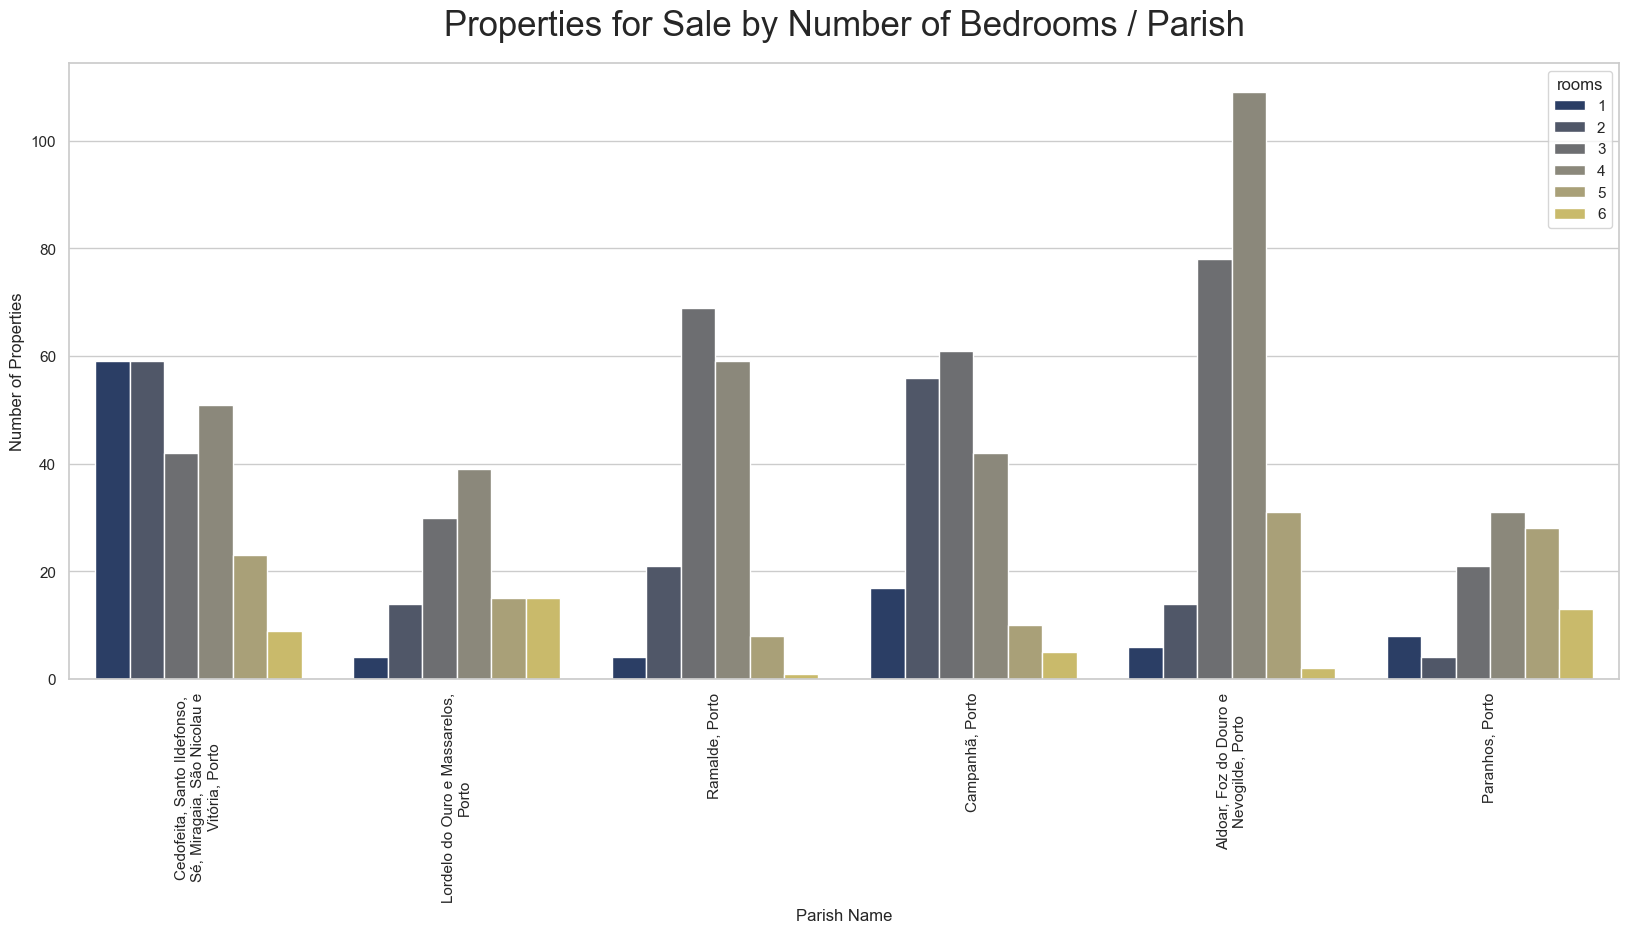

In [351]:
fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.countplot(hue = 'rooms',
              x = 'location',
              palette=custom_palette,
              data = porto_sell_df, ax = ax1);

ax1.set_title("Properties for Sale by Number of Bedrooms / Parish", fontsize=25, pad=20);
ax1.set_xlabel("Parish Name");
ax1.set_ylabel("Number of Properties");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);


The region closest to the historic center and also more touristy (Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau and Vitória) is the area that has proportionally more properties with fewer rooms. The explanation may be the older constructions and the properties' setting for tourism.

The more upscale area (Aldoar, Foz do Douro and Nevogilde) has a greater supply of properties with more rooms.

In general, the city has a greater availability of properties with 4, 3 and 2 rooms respectively. These properties represent approximately 75% of properties for sale in the city.

<h4 style = 'color: orange'> The average price per square meter:</h4>

In [352]:
porto_sell_df['m2_price'].mean()

3551.859593572779

The average price per square meter of a residential property in the city of Porto is € 3.551,85.

<h4 style = 'color: orange'> Which three parishes have the highest average price:</h4>

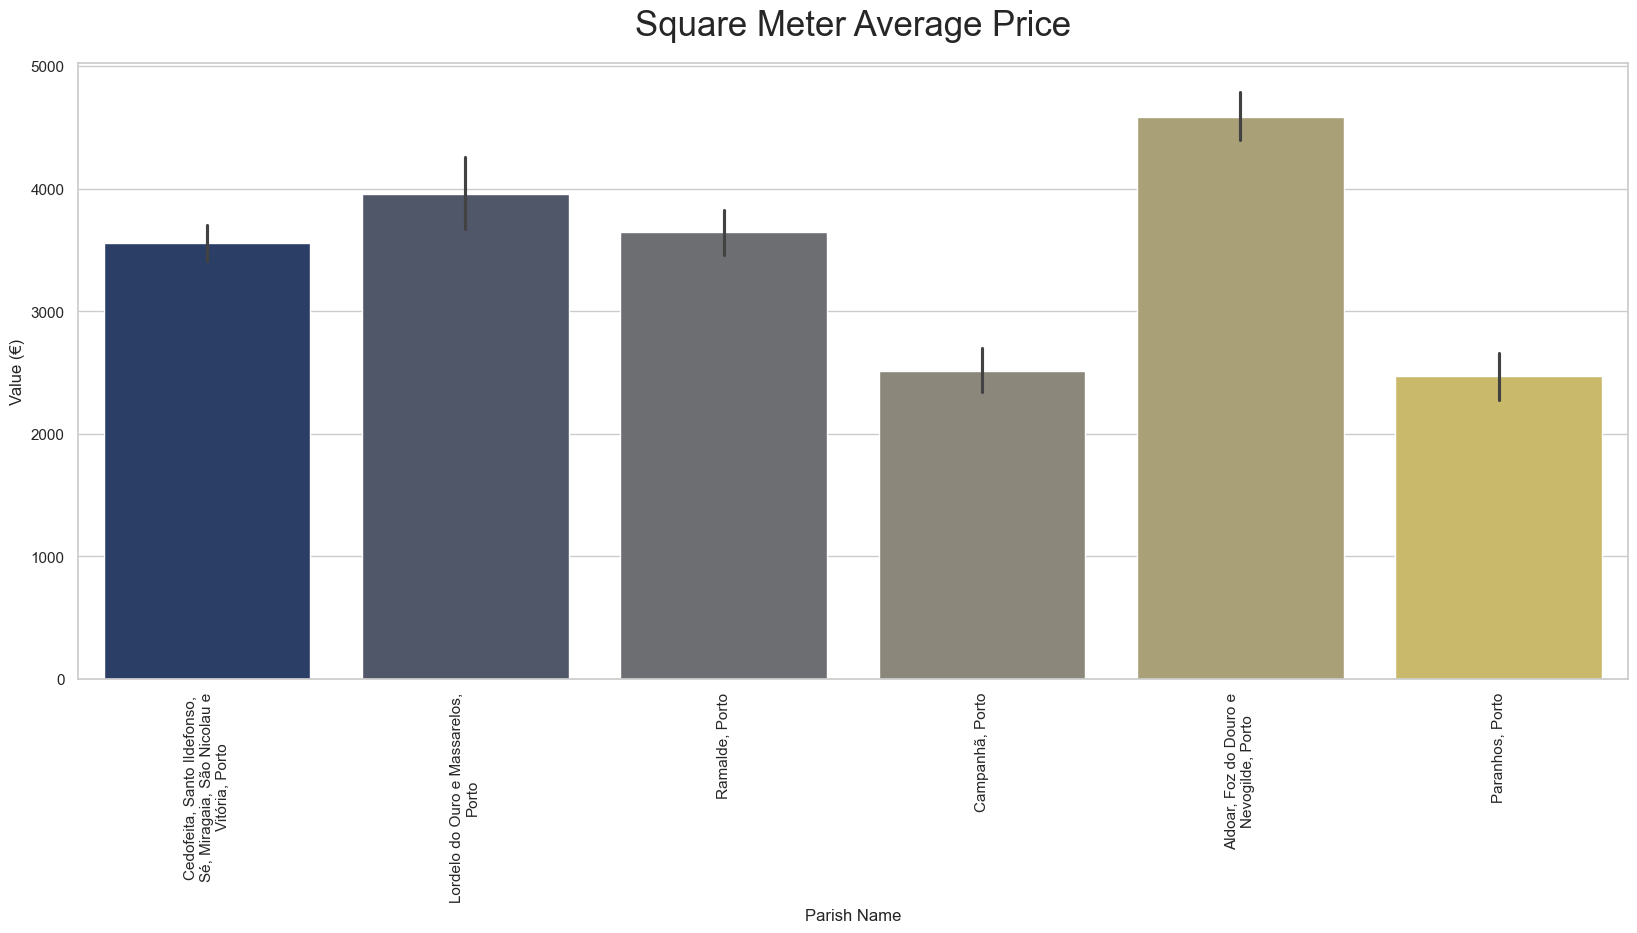

In [353]:
fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.barplot(hue = 'location',
              x = 'location',
              y = 'm2_price',
              palette=custom_palette,
              data = porto_sell_df, ax = ax1);
ax1.set_title("Square Meter Average Price", fontsize=25, pad=20);
ax1.set_xlabel("Parish Name");
ax1.set_ylabel("Value (€)");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);

In [354]:
for parish in ['Aldoar, Foz do Douro e Nevogilde, Porto', 'Lordelo do Ouro e Massarelos, Porto', 'Ramalde, Porto' ]:
    print(f'{parish}:{porto_sell_df.loc[porto_sell_df['location'] == parish, 'm2_price'].mean().round(2)}')

Aldoar, Foz do Douro e Nevogilde, Porto:4582.67
Lordelo do Ouro e Massarelos, Porto:3955.01
Ramalde, Porto:3648.78


The three parishes in Porto with the highest prices (square meters) are respectively: 

-   Aldoar, Foz do Douro e Nevogilde (€ 4.582,67);
-   Lordelo do Ouro e Massarelos (€ 3.955,01);
-   Ramalde (€ 3648,78).

<h4 style = 'color: orange'> Distribution of properties' price (by square meter) in each parish according to the number of rooms:</h4>

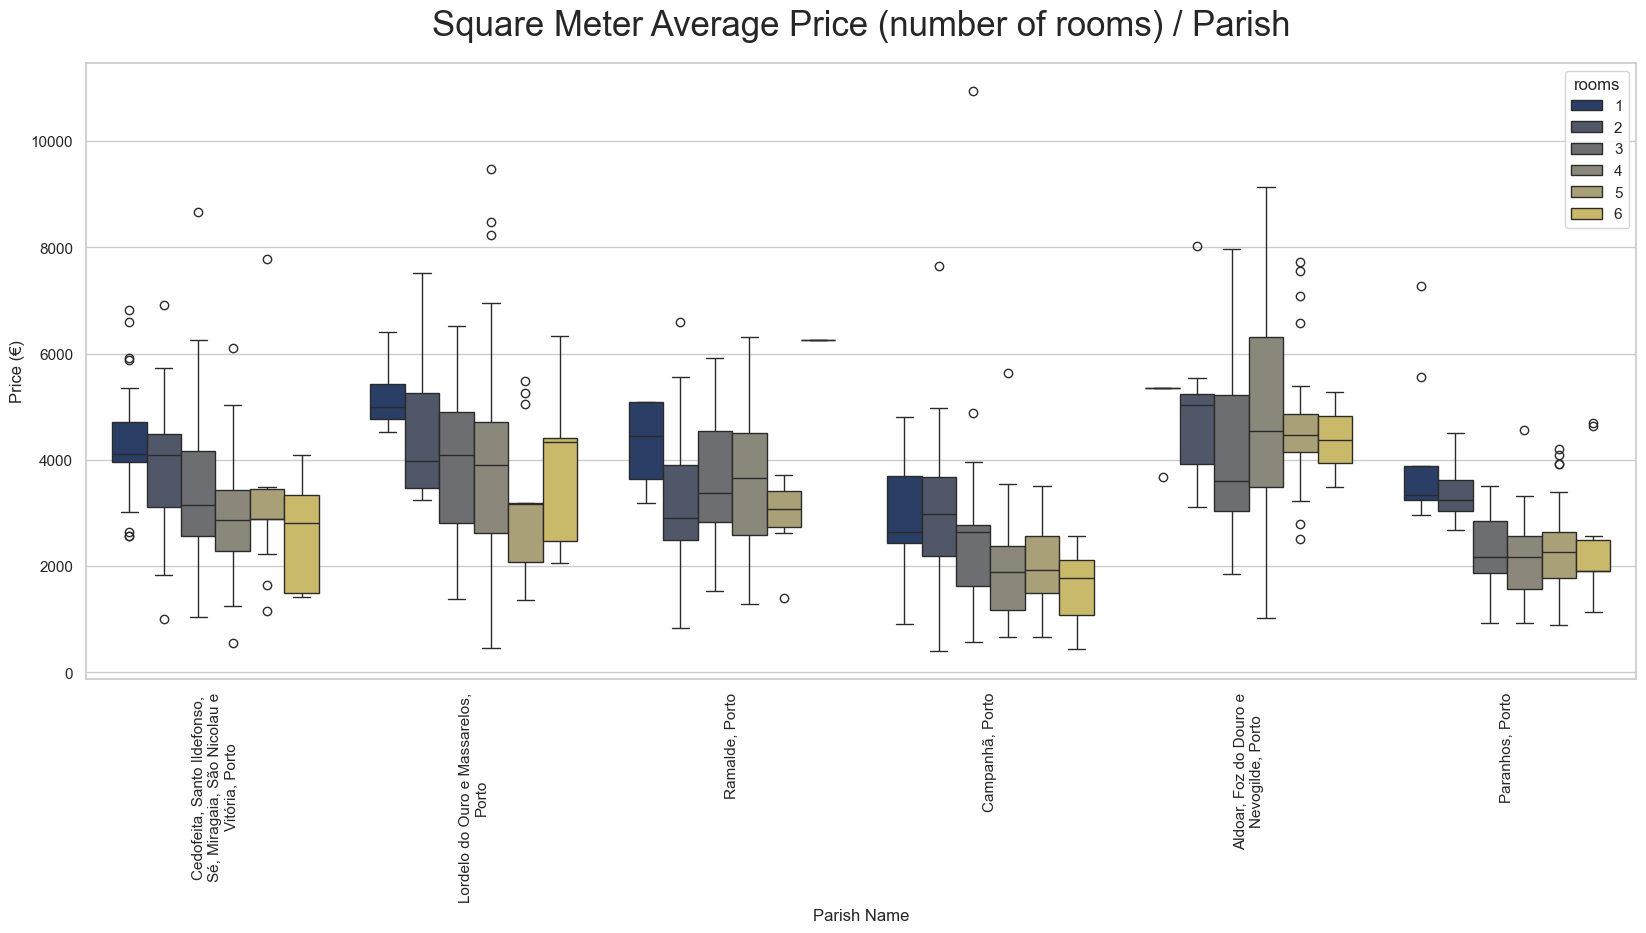

In [355]:
fig, (ax1) = plt.subplots(1, figsize=(20, 8))

sns.boxplot(hue = 'rooms',
              x = 'location',
              y = 'm2_price',
              palette=custom_palette,
              data = porto_sell_df, ax = ax1);
ax1.set_title("Square Meter Average Price (number of rooms) / Parish", fontsize=25, pad=20);
ax1.set_xlabel("Parish Name");
ax1.set_ylabel("Price (€)");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);

The logic known in the real estate market is confirmed: smaller properties have more expensive square meters. However, there are exceptions.

<h4 style = 'color: orange'> Proportion of the average properties price according to the number of rooms:</h4>

In [356]:
# DataFrame with the average price of properties by number of rooms:

proportion_price = porto_sell_df.groupby('rooms')['price'].mean().round().reset_index()
proportion_price

,rooms,price
0,1,236431.0
1,2,332026.0
2,3,594148.0
3,4,886712.0
4,5,874364.0
5,6,951420.0


In [357]:
# Create a column with the proportion of the price in relation to the previous property:
  
proportions = []

for i in range(1, len(proportion_price)):
    current_value = proportion_price.loc[i, 'price']
    previous_value = proportion_price.loc[i - 1, 'price']
    
    proportion = current_value / previous_value
    
    proportions.append(proportion)

proportions.insert(0, float('NaN'))

proportion_price['proportion'] = proportions

In [358]:
proportion_price

,rooms,price,proportion
0,1,236431.0,NaN
1,2,332026.0,1.404325
2,3,594148.0,1.789462
3,4,886712.0,1.492409
4,5,874364.0,0.986074
5,6,951420.0,1.088128


Based on the data, we understand the proportion of property prices according to the number of rooms. This is interesting information for real estate agents to have comparison parameters.

My analysis is that the sample size is insufficient to have robust information in this regard.

<h4 style = 'color: orange'> Generating the CSV file for ML:</h4>

In [359]:
porto_sell_df.to_csv('porto_sell_1to6_bedrooms.csv', index= False)